In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
import math
import json
import os
from threading import Thread
import multiprocessing as mp
import queue as queue #import queue
from networkx.algorithms import community
from matplotlib.pyplot import figure

# my functions implemented in ./src/
#rom vkprint import vkprint
from crawling_algorythms import Crawler_RC,Crawler_RW,Crawler_DFS,Crawler_BFS,Crawler_MOD,Crawler_MED, Crawler_DE,METRICS_LIST
from utils import import_graph,draw_graph,get_percentile,draw_percentile_heatmap
from utils import draw_nodes_history,draw_scores_history,dump_results

In [2]:
def treading_crawler(seed_num, big_graph, crawling_method,node_seed, b, percentile_set):
    """
    Paralleling algorythm. 1 process for 1 seed. Using global multiprocessing.Queue for export results
    :param seed_num:
    :param big_graph:
    :param crawling_method:
    :param node_seed:
    :param b:
    :param percentile_set:
    :return:
    """
    #global q
    #print('thread alive', seed_num, q.qsize())
    thread_crawler = crawling_method(big_graph, node_seed=node_seed, budget=b, percentile_set=percentile_set)

    counter = 0
    #thread_dump_file = open('../results/dumps/' + graph_name + '/method'+str(methods['RW'])[-5:-2]+seed'+str(node_seed)+str(b)+'.json', 'a+')
    #thread_dump_file.write('[')
    while counter < b:
        if counter % 100 == 9:
            print('counter',counter)#, end="\r")
        if counter % 10000 == 1:
            print(crawling_method,  counter, seed_num)  
            thread_dump_file = open('../results/dumps/'+ graph_name + '/method'+str(crawling_method)[-5:-2]+'seed'+str(node_seed)+'iter_'+str(counter)+'|'+str(b)+'.json', 'w')
            json.dump(thread_crawler.observed_history,thread_dump_file)
            thread_dump_file.close()                   
        counter += 1
        thread_crawler.sampling_process()
                   
        # if counter %100:
        # print(counter)
    # print(seed_num,thread_crawler.observed_history)
    # return_dict[seed_num] = thread_crawler.observed_history
    print('thread ready', seed_num, q.qsize())
    q.put(thread_crawler.observed_history)
    #print(seed_num, 'putted')

In [3]:
%%time
## макропараметры всей задачи
graph_name = 'wikivote'
methods = {'RW':Crawler_RW,'RC':Crawler_RC,'DFS':Crawler_DFS, 'BFS':Crawler_BFS, 'MOD':Crawler_MOD,'MED':Crawler_MED,'DE':Crawler_DE} #'AFD',
#methods = {'DE':Crawler_DE,'RC':Crawler_RC,'MOD':Crawler_MOD} #'AFD',

b = 1000
seed_count =4
top_percetile = 10

# общие множества и вспомогательное, лучше не менять

graph_name_list = ['importing','wikivote','hamsterster','DCAM','gnutella',  'dblp2010',  'github']  #'slashdot',
linestyles = [':', '--', '-.','--']*seed_count


# Дальше лучше не трогать
t00 = time.time()
big_graph = import_graph(graph_name)
b = min(big_graph.number_of_nodes(),b)
percentile, percentile_set = get_percentile(big_graph,graph_name,top_percetile) # берём топ 10 процентов вершин
if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
    percentile_set['eccentricity']=set(big_graph.nodes()).difference(percentile_set['eccentricity'])

nx.write_gml(big_graph, "../data/Graphs/"+ graph_name +'_BIG.graph')
print("big_graph "+graph_name+"\nb=",b,"seed count=",seed_count, "methods:",methods, "\n percentile",percentile)


#draw_graph(big_graph,graph_name) # отрисовываем граф, если не очень большой
seeds = random.sample(set(big_graph.nodes),seed_count) # список начальных вершин, по которым мы будем проходиться
crawler = dict()   
crawler_avg = dict()

seeds = random.sample(set(big_graph.nodes),seed_count)
history = dict((method, []*seed_count) for method in methods)
crawler = dict((method, {'nodes':[],'degrees':[],'k_cores':[],'eccentricity':[],
                                  'betweenness_centrality':[]}) for method in methods)
crawler_avg = dict((method, {'nodes':[],#np.zeros([len(methods)*seed_count,b+1]),
                                  'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}) for method in methods)



# для каждого метода отдельный список тредов, и всё в виде словаря
threads =dict()

for method in methods:   
    #process_queue = list(seeds)    
    #while len(process_queue)>0:
    crawler_avg[method] = dict({i: np.zeros(b) for i in METRICS_LIST}, **{'nodes': np.zeros(b)})
    property_history_hist = {'nodes':[],'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}
    
    threads [method] = []
    
    for seed_num in range(seed_count):
        #process_method = process_queue.pop()
        t0 =time.time()
        #algorythm = methods[method]
        
    
    q = mp.Queue()
    for seed_num in range(seed_count):
        threads[method].append(mp.Process(daemon = True,target=treading_crawler, args=(seed_num,big_graph,methods[method],seeds[seed_num],b,percentile_set)))
        #threads[method][seed_num].setDaemon = True
        #print('starting')
        threads[method][seed_num].start()
        
    for seed_num in range(seed_count):
        #print('appending')
        debug_getted = q.get()
        #print('debug getted', debug_getted)
        history[method].append(debug_getted)
        
    q.close()
    q.join_thread()    
    
    
    for seed_num in range(seed_count):
        threads[method][seed_num].join()
        #print('calc avg props')
        for prop in METRICS_LIST:
            property_history_hist[prop] = np.array([i for i in history[method][seed_num][prop]])
            crawler_avg[method][prop] += property_history_hist[prop]
        #print('calc avg nodes')
        crawler_avg[method]['nodes'] += np.array(history[method][seed_num]['nodes'])
        
    #dump_results(graph_name,big_graph,crawler_avg,history)
    print(graph_name, seed_count, method, seed_num,' it took ', round(((time.time() -t0)/60),3),'minutes'  )
dump_results(graph_name,crawler_avg,history,b)
    


big_graph DCAM
b= 10 seed count= 8 methods: {'RW': <class 'crawling_algorythms.Crawler_RW'>, 'RC': <class 'crawling_algorythms.Crawler_RC'>, 'DFS': <class 'crawling_algorythms.Crawler_DFS'>, 'BFS': <class 'crawling_algorythms.Crawler_BFS'>, 'MOD': <class 'crawling_algorythms.Crawler_MOD'>, 'MED': <class 'crawling_algorythms.Crawler_MED'>, 'DE': <class 'crawling_algorythms.Crawler_DE'>} 
 percentile {'degrees': 123, 'k_cores': 53, 'eccentricity': 3, 'betweenness_centrality': 6062}
starting
starting
counter 2
<class 'crawling_algorythms.Crawler_RW'> 1 0
starting
counter 2
thread ready 0 0
starting
<class 'crawling_algorythms.Crawler_RW'> 1 1
starting
counter 2
thread ready 1 1
<class 'crawling_algorythms.Crawler_RW'> 1 2
thread ready 2 2
counter 2
starting
<class 'crawling_algorythms.Crawler_RW'> 1 3
starting
counter 2
thread ready 3 3
starting
<class 'crawling_algorythms.Crawler_RW'> 1 5
counter 2
<class 'crawling_algorythms.Crawler_RW'> 1 4
counter 2
thread ready 5 4
thread ready 4 4
<

counter 2
thread ready 3 3
thread ready 5 4
<class 'crawling_algorythms.Crawler_DFS'> 1 6
counter 2
thread ready 6 1
<class 'crawling_algorythms.Crawler_DFS'> 1 7
debug getted {'degrees': [0, 1, 2, 3, 4, 5, 5, 5, 5, 5], 'k_cores': [0, 1, 2, 2, 2, 2, 2, 2, 2, 2], 'eccentricity': [1, 2, 3, 4, 5, 6, 6, 6, 6, 6], 'betweenness_centrality': [0, 1, 2, 3, 4, 5, 5, 5, 5, 5], 'nodes': [48, 165, 481, 505, 546, 564, 565, 578, 592, 597]}
appending
debug getted {'degrees': [0, 1, 2, 3, 4, 4, 4, 4, 4, 4], 'k_cores': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'eccentricity': [0, 1, 2, 3, 4, 4, 4, 4, 4, 4], 'betweenness_centrality': [0, 1, 2, 3, 4, 4, 4, 4, 4, 4], 'nodes': [53, 352, 376, 416, 433, 434, 447, 461, 466, 468]}
appending
thread ready 7 0
debug getted {'degrees': [0, 1, 2, 3, 4, 5, 5, 5, 5, 5], 'k_cores': [0, 1, 1, 2, 2, 2, 2, 2, 2, 2], 'eccentricity': [0, 1, 2, 3, 4, 5, 5, 5, 5, 5], 'betweenness_centrality': [0, 1, 2, 3, 4, 5, 5, 5, 5, 5], 'nodes': [13, 869, 969, 1063, 1102, 1115, 1115, 1122, 1133, 11

thread ready 2 0
debug getted {'degrees': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'k_cores': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'eccentricity': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'betweenness_centrality': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'nodes': [87, 890, 1205, 1283, 1330, 1398, 1420, 1449, 1475, 1498]}
appending
thread ready 1 1
debug getted {'degrees': [0, 0, 0, 1, 2, 3, 4, 5, 6, 7], 'k_cores': [0, 0, 0, 1, 2, 3, 4, 5, 6, 7], 'eccentricity': [0, 0, 0, 1, 2, 3, 4, 5, 6, 7], 'betweenness_centrality': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'nodes': [2, 7, 14, 314, 956, 1263, 1333, 1381, 1449, 1470]}
appending
debug getted {'degrees': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'k_cores': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'eccentricity': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'betweenness_centrality': [0, 0, 1, 2, 3, 4, 5, 6, 7, 8], 'nodes': [5, 159, 914, 1218, 1285, 1332, 1405, 1424, 1456, 1478]}
appending
thread ready 5 0
debug getted {'degrees': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'k_cores': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'ecce

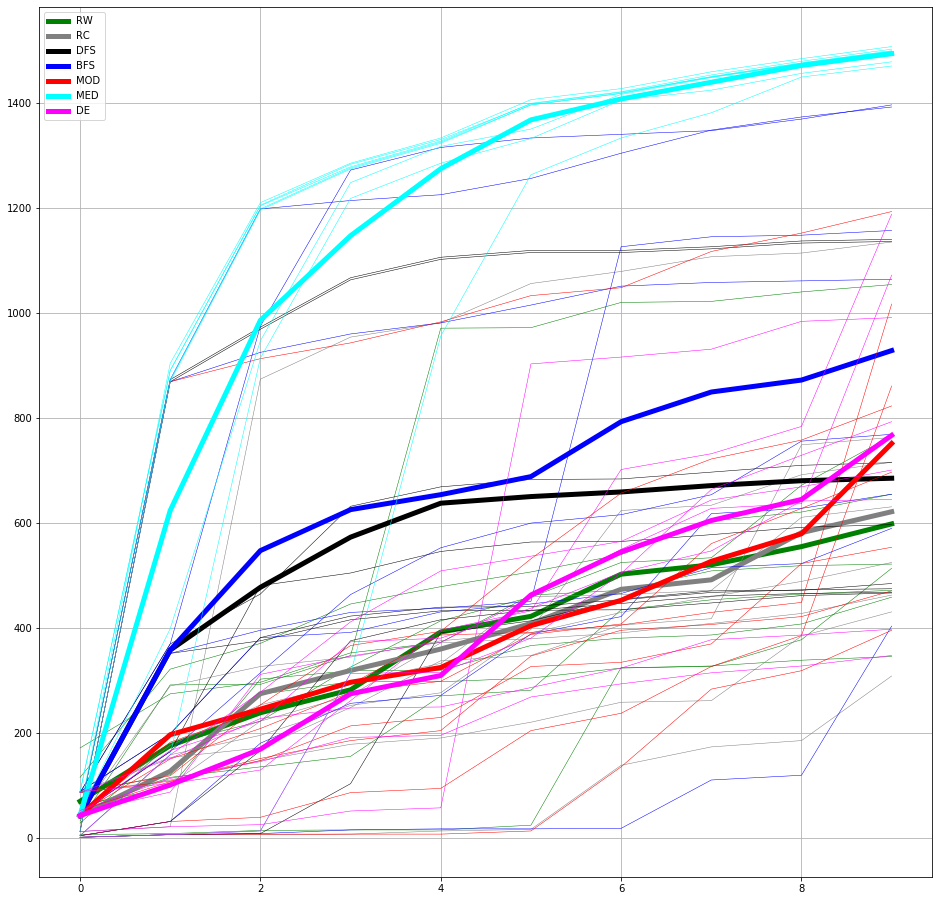

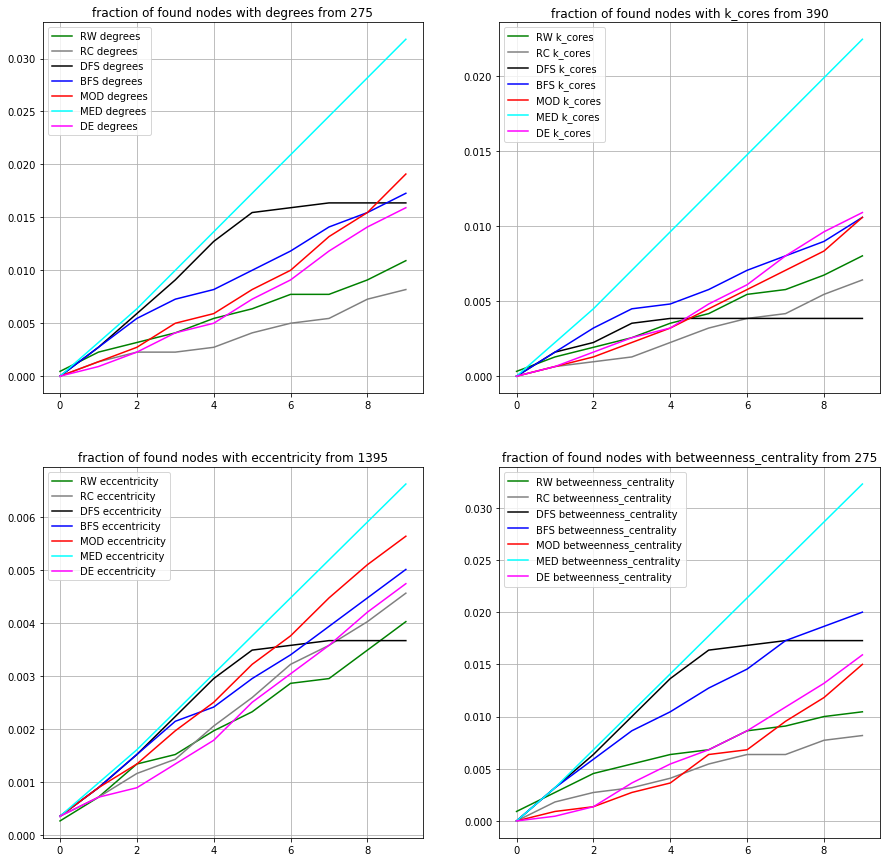

<Figure size 2160x2160 with 0 Axes>

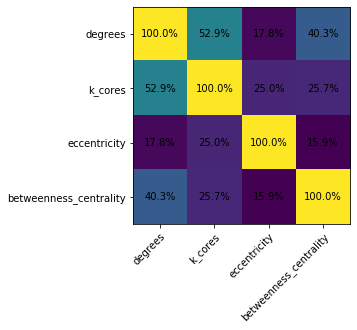

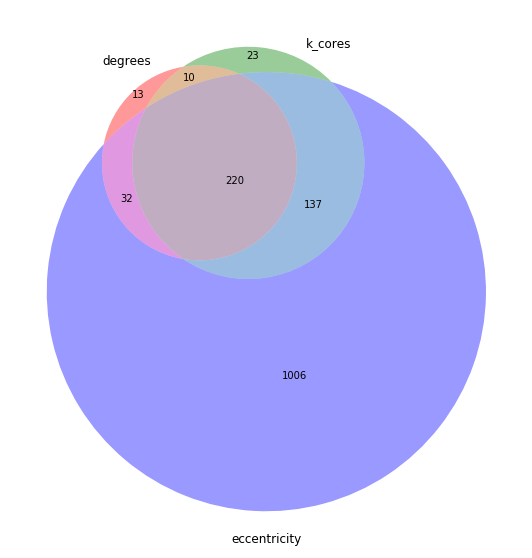

i have done everything!!!!


In [4]:
if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
    percentile_set['eccentricity']=set(big_graph.nodes()).difference(percentile_set['eccentricity'])

draw_nodes_history(history,crawler_avg, methods,graph_name,seed_count,b)
percentile, percentile_set = get_percentile(big_graph,graph_name,top_percetile) # берём топ 10 процентов вершин
draw_scores_history(percentile_set,crawler_avg,methods,graph_name,seed_count,b)
draw_percentile_heatmap(percentile_set,graph_name,seed_count,b, normalized=True, venn_on=True)


print('i have done everything!!!!')